[Reference](https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9)

In [14]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

df = pd.read_csv('https://raw.githubusercontent.com/Branden-Kang/Time-Series-Analysis/master/Data/JNJ.csv')
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2020-05-28 00:00:00'), Timestamp('2021-05-28 00:00:00'))

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Johnson and Johnson Stock Price 1985-2020')
fig.show()

In [16]:
train, test = df.loc[df['Date'] <= '2021-05-01'], df.loc[df['Date'] > '2020-06-01']
train.shape, test.shape

((234, 2), (251, 2))

In [17]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (204, 30, 1)
Testing shape: (221, 30, 1)


In [19]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [20]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
6/6 [==============================] - 4s 204ms/step - loss: 0.5549 - val_loss: 0.3161
Epoch 2/100
6/6 [==============================] - 0s 72ms/step - loss: 0.3885 - val_loss: 0.2841
Epoch 3/100
6/6 [==============================] - 0s 78ms/step - loss: 0.3638 - val_loss: 0.3850
Epoch 4/100
6/6 [==============================] - 0s 73ms/step - loss: 0.2929 - val_loss: 0.3553
Epoch 5/100
6/6 [==============================] - 0s 76ms/step - loss: 0.2836 - val_loss: 0.2991


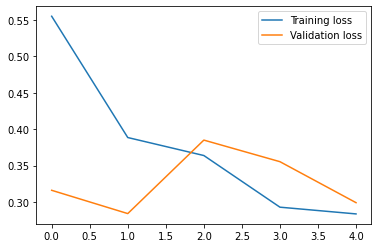

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [22]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 18ms/step - loss: 0.2583


0.25826704502105713

Reconstruction error threshold: 1.0925887984422764


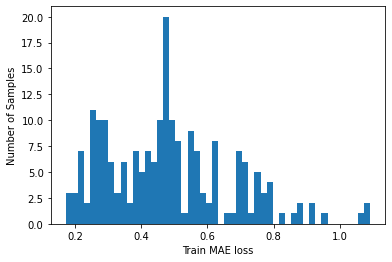

In [23]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

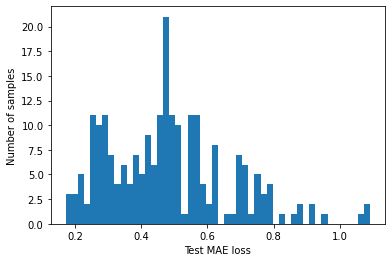

In [24]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [25]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [26]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(0, 5)

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()